In [1]:
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import scipy

from statsmodels.distributions.empirical_distribution import ECDF
from mc_simulation import AverageModel as am
from mc_simulation import VolatilityModel as vm
from mc_simulation import MonteCarloSimulation as mcs

%matplotlib inline

In [2]:
df = pd.read_excel("Options1.xlsx", sheet_name = 5) #spxall, GE, EXXO, BAO, MMMO, RTXO, LMTO, WMTO, 
df = df[:len(df)-1]
df.head()

,Strike,Ticker,Bid,Ask,Last,IVM,Maturity,Type,Terror
0,900,SPXW 4/30/21 C900,2940.100098,2951.899902,0.0,0.0,94,Call,0
1,1000,SPXW 4/30/21 C1000,2840.300049,2852.100098,0.0,0.0,94,Call,0
2,1100,SPXW 4/30/21 C1100,2740.600098,2752.399902,0.0,0.0,94,Call,0
3,1200,SPXW 4/30/21 C1200,2640.899902,2652.699951,0.0,0.0,94,Call,0
4,1300,SPXW 4/30/21 C1300,2541.300049,2553.000000,0.0,0.0,94,Call,0


In [3]:
act = pd.read_csv("GSPC2.csv") #GSPC2, GEst, XOM, BA, ( MMM ), ( RTX ), ( LMT ), ( WMT )
act.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume
750,2021-01-13,3802.229980,3820.959961,3791.500000,3809.840088,3809.840088,4590420000
751,2021-01-14,3814.979980,3823.600098,3792.860107,3795.540039,3795.540039,5180140000
752,2021-01-15,3788.729980,3788.729980,3749.620117,3768.250000,3768.250000,5353060000
753,2021-01-19,3781.879883,3804.530029,3780.370117,3798.909912,3798.909912,4982940000
754,2021-01-20,3816.219971,3859.750000,3816.219971,3851.850098,3851.850098,4551790000


In [4]:
actuals = act["Close"]
mvol =((np.var(actuals)**0.5)/np.mean(actuals))**(1/(len(actuals)/365.5))
r = 0.0025
T = 42/365
S = float(actuals[len(actuals)-1:len(actuals)])

In [5]:
rs = "STR"
df_call = df[df["Type"]=="Call"]
X_call = df_call["Strike"]
Bid_init_call = np.array(df_call["Bid"])
Ask_init_call = np.array(df_call["Ask"])
K_call = list()
P_call = list()
Bid_call = list()
Ask_call = list()
for i in range (0,len(X_call)):
    if type(X_call[i]) == type(rs):
        k = float(X_call[i].replace(",", ""))
        K_call.append(k)
    else:
        k = float(X_call[i])
        K_call.append(k)

for i in range (0,len(Bid_init_call)):
    if type(Bid_init_call[i]) == type(rs):
        b = float(Bid_init_call[i].replace(",", ""))
        Bid_call.append(b)
    else:
        b = float(Bid_init_call[i])
        Bid_call.append(b)

for i in range (0,len(Ask_init_call)):
    if type(Ask_init_call[i]) == type(rs):
        a = float(Ask_init_call[i].replace(",", ""))
        Ask_call.append(a)
    else:
        a = float(Ask_init_call[i])
        Ask_call.append(a)
        
P_call = np.round(np.add(Ask_call, Bid_call)/2, 2)

# RND Simulation for S&P

In [6]:
N = norm.cdf

def bs_call(S, K, T, r, vol):
    d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)

def bs_put(S, K, T, r, vol):
    d1 = -1*((np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T)))
    d2 = -1*(d1 - vol * np.sqrt(T))
    return -1*(S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2))

def bs_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def find_vol_call(target_value, S, K, T, r, *args):
    MAX_ITERATIONS = 1000
    PRECISION = 1.0e-10
    sigma = 1
    for i in range(0, MAX_ITERATIONS):
        price = bs_call(S, K, T, r, sigma)
        vega = bs_vega(S, K, T, r, sigma)
        diff = target_value - price  # our root
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega/100 # f(x) / f'(x)
    return sigma # value wasn't found, return best guess so far

def find_vol_put(target_value, S, K, T, r, *args):
    MAX_ITERATIONS = 1000
    PRECISION = 1.0e-10
    sigma = 1
    for i in range(0, MAX_ITERATIONS):
        price = bs_put(S, K, T, r, sigma)
        vega = bs_vega(S, K, T, r, sigma)
        diff = target_value - price  # our root
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega/100 # f(x) / f'(x)
    return sigma # value wasn't found, return best guess so far

In [7]:
iv = list()
ST = list()
for i in range(0, len(K_call)):
    v = find_vol_call(float(P_call[i]), S, float(K_call[i]), T, r)
    if str(v) == "nan":
        v = 0
    else:
        iv.append(v)
        ST.append(float(K_call[i]))

/var/folders/q0/ssgw9m190y10ltp1vb2rcthw0000gn/T/ipykernel_62527/2175569474.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  sigma = sigma + diff/vega/100 # f(x) / f'(x)
/var/folders/q0/ssgw9m190y10ltp1vb2rcthw0000gn/T/ipykernel_62527/2175569474.py:4: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
/var/folders/q0/ssgw9m190y10ltp1vb2rcthw0000gn/T/ipykernel_62527/2175569474.py:14: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


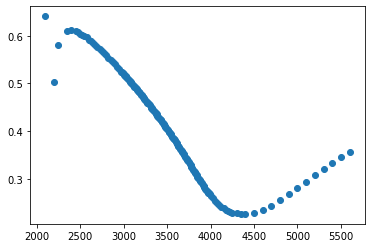

In [8]:
plt.scatter(ST, np.array(iv))

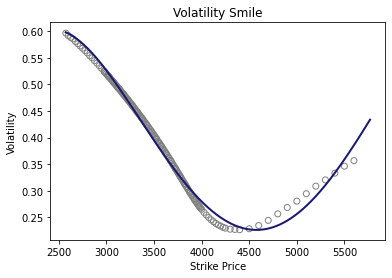

In [9]:
vols = list()
Strikes = np.linspace(int(np.round((1-1*mvol)*S)),int(np.round((1+1.5*mvol)*S)), num = 2*int(np.round((1+0.7*mvol)*S)-np.round((1-0.7*mvol)*S)))
coef = np.polyfit(ST ,iv, deg=4)
for k in Strikes:
    vol = coef[0]*(k**4)+coef[1]*(k**3)+coef[2]*(k**2)+coef[3]*k+coef[4]
    vols.append(vol)
plt.plot(Strikes, vols, linewidth=2.0, c='midnightblue')
plt.scatter(ST[10:], np.array(iv)[10:], facecolors='none', edgecolors='gray')
plt.title('Volatility Smile');
plt.xlabel('Strike Price');
plt.ylabel('Volatility');

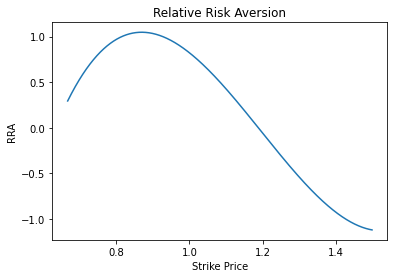

In [10]:
RRAM = list()
MN = list()
for i in range (0, len(Strikes)):
    mn = Strikes[i]/S
    MN.append(mn)
for i in range (1, len(Strikes)):
    rram = -(vols[i]-vols[i-1])/(MN[i]-MN[i-1])
    RRAM.append(rram)
plt.plot(MN[1:], RRAM)
plt.title('Relative Risk Aversion');
plt.xlabel('Strike Price');
plt.ylabel('RRA');

In [11]:
bsp = list()
for i in range(0, len(Strikes)):
    bs = bs_call(S, float(Strikes[i]), T, r, float(vols[i]))
    bsp.append(bs)

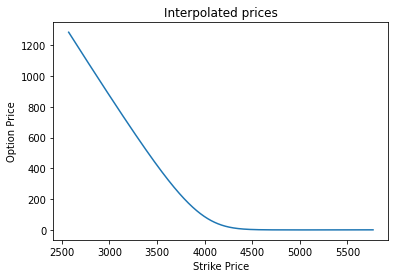

In [12]:
plt.plot(Strikes, bsp)
plt.title('Interpolated prices');
plt.xlabel('Strike Price');
plt.ylabel('Option Price');

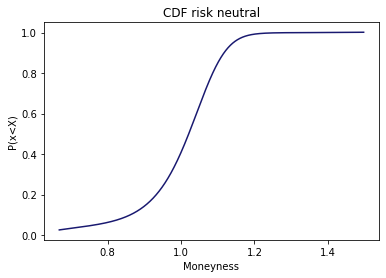

In [13]:
CDF1 = []
Moneyness1 = []
for i in range (1, len(Strikes)):
    Mn = Strikes[i]/S
    cdf = ((bsp[i]/S-bsp[i-1]/S)/(Strikes[i]/S - Strikes[i-1]/S))*np.exp(r*T)+1
    Moneyness1.append(Mn)
    CDF1.append(cdf)
plt.plot(Moneyness1, CDF1, c='midnightblue')
plt.title('CDF risk neutral');
plt.xlabel('Moneyness');
plt.ylabel('P(x<X)');

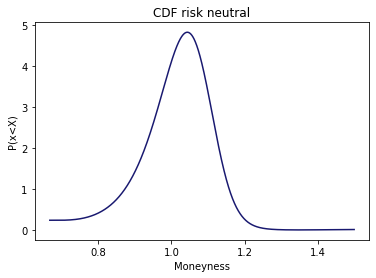

In [14]:
PDF = [(CDF1[i] - CDF1[i-1])/(Moneyness1[i] - Moneyness1[i-1]) for i in range(1, len(CDF1))]
plt.plot(Moneyness1[1:], PDF, c='midnightblue')
plt.title('CDF risk neutral');
plt.xlabel('Moneyness');
plt.ylabel('P(x<X)');

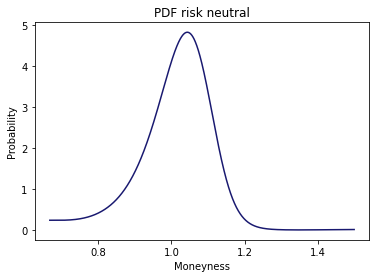

In [15]:
PDF1 = []
for i in range (1, len(Strikes)-1):
    pdf = ((bsp[i+1] - 2 * bsp[i] + bsp[i-1])/S / ((Moneyness1[i] - Moneyness1[i-1])**2))
    PDF1.append(pdf)

plt.plot(Moneyness1[1:], PDF1, c='midnightblue')

plt.title('PDF risk neutral');
plt.xlabel('Moneyness');
plt.ylabel('Probability');

# Actual distribution

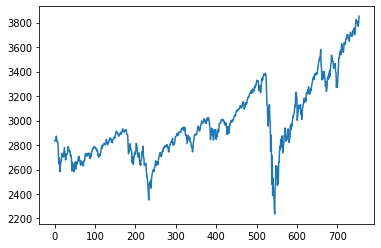

In [16]:
plt.plot(actuals)

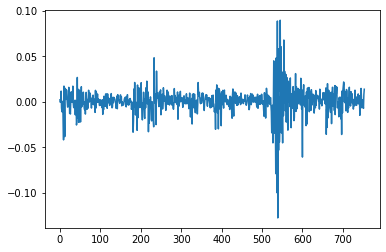

In [17]:
log_returns = list()
for i in range (0, len(actuals)-1):
    vv = np.log(actuals[i+1]/actuals[i])
    log_returns.append(vv)
plt.plot(log_returns)

In [19]:
ss.kstest(log_returns, "norm")

KstestResult(statistic=0.47459816677647326, pvalue=1.7611183746841772e-156)

In [20]:
u = np.mean(log_returns)
v = np.var(log_returns)
drift = u - 0.5 * v
std = np.std(log_returns)

In [21]:
t_intervals = 45
iterations = 16000
daily_returns = np.exp(drift + std *ss.norm.ppf(np.random.rand(t_intervals, iterations)))

In [22]:
price_list = np.zeros_like(daily_returns)
price_olds = np.zeros((len(actuals)-1,iterations))
for i in range (0, len(price_olds)):
    price_olds[i]=actuals[i]
price_list[0] = S

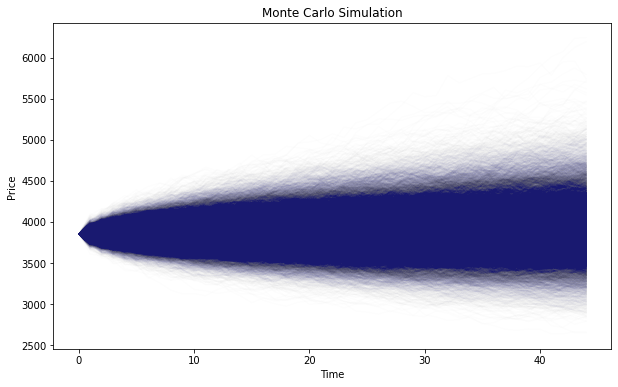

In [23]:
for t in range(1, t_intervals):
    price_list[t] = price_list[t - 1] * daily_returns[t]
plt.figure(figsize=(10,6))
plt.plot(price_list, alpha =0.008, color = 'midnightblue');
plt.title('Monte Carlo Simulation');
plt.xlabel('Time');
plt.ylabel('Price');

In [24]:
Last_day = price_list[-1]
sample = Last_day/S
ecdf = ECDF(sample)

x = np.linspace(min(sample), max(sample), num=len(PDF1)+1)
y = ecdf(x)

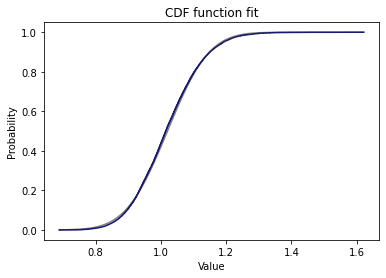

In [25]:
params = ss.norm.fit(sample)
norms = ss.norm.cdf(x, params[0], params[1])
normspdf = ss.norm.pdf(x, params[0], params[1])
plt.plot(x, norms, color = 'gray')
plt.step(x, y, color = "midnightblue")
plt.title('CDF function fit');
plt.xlabel('Value');
plt.ylabel('Probability');

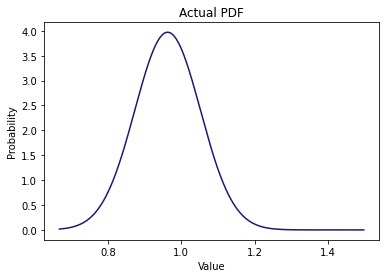

In [26]:
params = ss.norm.fit(sample)
norms = ss.norm.cdf(x, params[0], params[1])
normspdf = ss.norm.pdf(x, params[0], params[1])
plt.plot(Moneyness1, normspdf, color = 'midnightblue')
plt.title('Actual PDF');
plt.xlabel('Value');
plt.ylabel('Probability');

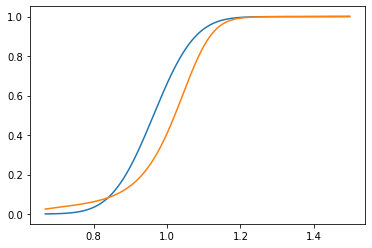

In [27]:
plt.plot(Moneyness1, norms)
plt.plot(Moneyness1, CDF1)

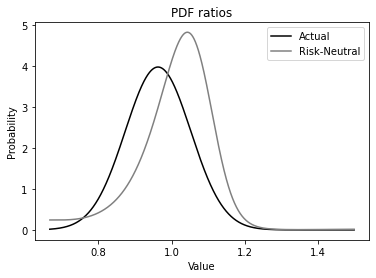

In [28]:
plt.plot(Moneyness1, normspdf, color = 'black', label = 'Actual')
plt.title('PDF ratios');
plt.xlabel('Value');
plt.ylabel('Probability');
plt.legend();
plt.plot(Moneyness1[1:], PDF, color = 'gray', label = 'Risk-Neutral')
plt.legend();

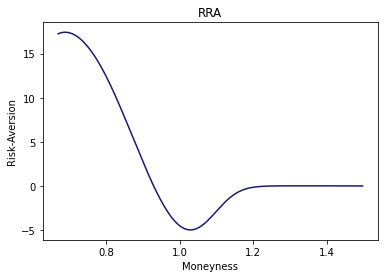

In [29]:
RA = list()
ARA = list()
RRA = list()
for i in range (0, len(Moneyness1)-1):
    risk_av = normspdf[i]/PDF[i] #Using Kernel (Jackwerth 2000)
    risk_av1 = normspdf[i]/norms[i]-PDF[i]/CDF1[i] #Using ARA  (Levy 2003)
    risk_rav1 = Moneyness1[i]*(normspdf[i]/norms[i]-PDF[i]/CDF1[i]) #Using RRA  (Levy 2003)
    RA.append(risk_av)
    ARA.append(risk_av1)
    RRA.append(risk_rav1)
plt.plot(Moneyness1[1:], RRA, color = 'midnightblue')
plt.title('RRA');
plt.xlabel('Moneyness');
plt.ylabel('Risk-Aversion');